# Rgrese

### Data

  * Zdrojem dat je soubor `LifeExpectancyData.csv` (originál zde: https://www.kaggle.com/kumarajarshi/life-expectancy-who).
  * Vysvětlovaná proměnná se jmenuje `Life expectancy `.

## Vypracování úkolu

In [2]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split 
import sklearn.metrics as metrics
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

from scipy import optimize
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline

### Základní info o datasetu 

In [3]:
df = pd.read_csv("LifeExpectancyData.csv")
df.head()

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


In [4]:
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Country                          2938 non-null   object 
 1   Year                             2938 non-null   int64  
 2   Status                           2938 non-null   object 
 3   Life expectancy                  2928 non-null   float64
 4   Adult Mortality                  2928 non-null   float64
 5   infant deaths                    2938 non-null   int64  
 6   Alcohol                          2744 non-null   float64
 7   percentage expenditure           2938 non-null   float64
 8   Hepatitis B                      2385 non-null   float64
 9   Measles                          2938 non-null   int64  
 10   BMI                             2904 non-null   float64
 11  under-five deaths                2938 non-null   int64  
 12  Polio               

Country                              0
Year                                 0
Status                               0
Life expectancy                     10
Adult Mortality                     10
infant deaths                        0
Alcohol                            194
percentage expenditure               0
Hepatitis B                        553
Measles                              0
 BMI                                34
under-five deaths                    0
Polio                               19
Total expenditure                  226
Diphtheria                          19
 HIV/AIDS                            0
GDP                                448
Population                         652
 thinness  1-19 years               34
 thinness 5-9 years                 34
Income composition of resources    167
Schooling                          163
dtype: int64

### Vypořádání se s chybějícími hodnotami

Jako první odstraním všechny řádky neobsahující údaj ve sloupci "Life expectancy", jak je napsáno v zadání. 

In [5]:
df.dropna(subset=["Life expectancy "], inplace=True)
df.isnull().sum()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2928 entries, 0 to 2937
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Country                          2928 non-null   object 
 1   Year                             2928 non-null   int64  
 2   Status                           2928 non-null   object 
 3   Life expectancy                  2928 non-null   float64
 4   Adult Mortality                  2928 non-null   float64
 5   infant deaths                    2928 non-null   int64  
 6   Alcohol                          2735 non-null   float64
 7   percentage expenditure           2928 non-null   float64
 8   Hepatitis B                      2375 non-null   float64
 9   Measles                          2928 non-null   int64  
 10   BMI                             2896 non-null   float64
 11  under-five deaths                2928 non-null   int64  
 12  Polio               

Ještě si převedu nenumerické příznaky na numerické. Udělám to před rozdělením na množiny, aby například všechny státy měly stejnou přiřazenou hodnotu. 

In [6]:
objects = df.select_dtypes(['object']).columns
df[objects] = df[objects].astype('category').apply(lambda x: x.cat.codes)

### Vypořádání se s chybějícími hodnotami

V datasetu je možné si všimnout, že u některých příznaků chybí jen pár hodnot pro daný stát. Je také možné si všimnout. že data pro daný stát se během doby jejich sběru výrazně nezměnila. Proto ještě před rozdělením na trénovací, testovací a validační množinu využiji tohoto faktu a v případě, že lze chybějící hodnotu doplnit průměrem ostatních známých hodnot pro daný stát doplním ji.

In [7]:
countries = np.unique(df.Country.values)
columns_with_missing_values = []
def fill_value_per_country(df):
    for column in df.columns:
        if df[column].isnull().sum() != 0:
            columns_with_missing_values.append(column)
    for column in df.columns:
        if df[column].isnull().sum() != 0:
            for country in countries:
                mean = df.loc[df["Country"] == country, column].mean()
                df.loc[df["Country"] == country, column] = df.loc[df["Country"] == country, column].fillna(mean)

In [8]:
fill_value_per_country(df)

In [9]:
df.isnull().sum()

Country                              0
Year                                 0
Status                               0
Life expectancy                      0
Adult Mortality                      0
infant deaths                        0
Alcohol                             16
percentage expenditure               0
Hepatitis B                        144
Measles                              0
 BMI                                32
under-five deaths                    0
Polio                                0
Total expenditure                   32
Diphtheria                           0
 HIV/AIDS                            0
GDP                                400
Population                         640
 thinness  1-19 years               32
 thinness 5-9 years                 32
Income composition of resources    160
Schooling                          160
dtype: int64

Je vidět, že v některých sloupcích to trochu pomohlo, např.  ve sloupci "Alcohol" se počet prázdných hodnoz snížil z 190 na 16 nebo u žloutenky typu B ze zhruba 500 na 144.

### Rozdělení na trénovací, testovací a validační množinu

In [1]:
random_seed = 42

train,val = train_test_split(df, test_size=0.5, random_state=random_seed)
val, test = train_test_split(val, test_size=0.5, random_state=random_seed)

NameError: name 'train_test_split' is not defined

Z důvodu stále velkého množství chybějících hodnot ve sloupci "population"  jsem se rozhodla tento sloupec úplně odstranit z datasetu.

In [11]:

train.drop(["Population"], axis=1, inplace=True)
test.drop(["Population"], axis=1, inplace=True)
val.drop(["Population"], axis=1, inplace=True)

Zbylé chybějící hodnoty tedy doplním celkovým průměrem. Zvolím funkci SimpleImputer z sklearn. 

In [12]:

def fill_the_missing_values(df):
    # create a array of all columns with some missing values
    columns_with_missing_values = []
    for column in df.columns:
        if df[column].isnull().sum() != 0:
            columns_with_missing_values.append(column)

    # create and imputer, which will fill all missing values with mean of its column
    imputer = SimpleImputer(strategy='mean', missing_values=np.nan)
    imputer = imputer.fit(df[columns_with_missing_values])
    df[columns_with_missing_values] = imputer.transform(df[columns_with_missing_values])    

In [13]:
fill_the_missing_values(train)
fill_the_missing_values(test)
fill_the_missing_values(val)

### Sestavení regresního modelu

Jako první si rozdělím již připravené množiny (train, test, val) na X - obsahující příznaky na základě kterých se bude model rozhodovat a y - které bude obsahovat pouze cílovou predikovanou proměnnou, v mém případě "Life expectancy ". 

In [14]:
Xtrain = train.drop(["Life expectancy "], axis=1)
ytrain = train["Life expectancy "]
Xtest = test.drop(["Life expectancy "], axis=1)
ytest = test["Life expectancy "]
Xval = val.drop(["Life expectancy "], axis=1)
yval = val["Life expectancy "]

Jako první aplikuji lineární regresi. Pomocí naimplementované metriky v sklearn "mean_squared_error"  a "mean_absolure_error" si vyjádřím chybu. Pro vyjádření RMSE místo MSE stačí nastavit parametr squared=False

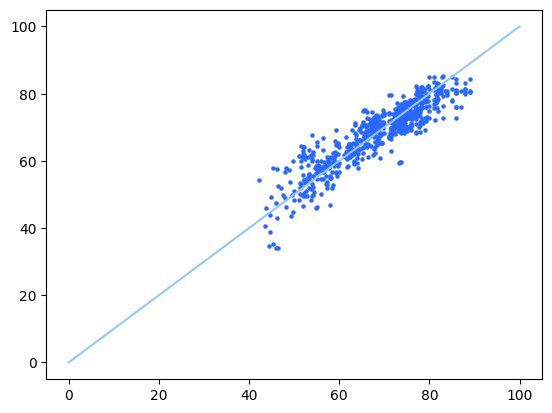

Intercept: 41.101495392770666
RMSE for val: 4.126519235588156
RMSE for test: 4.032187999542147
MAE for val: 3.09074334559559
MAE for test: 3.040450984280501


In [16]:
clf_lr = LinearRegression()
clf_lr.fit(Xtrain,ytrain)

plt.scatter(yval, clf_lr.predict(Xval), color="#2968ff", s=5)
plt.plot([0,100], [0,100], '#94c6ff')
plt.show()

print('Intercept:', clf_lr.intercept_)
print('RMSE for val:', mean_squared_error(yval, clf_lr.predict(Xval), squared=False))
print('RMSE for test:',mean_squared_error(ytest, clf_lr.predict(Xtest), squared=False))
print('MAE for val:', mean_absolute_error(clf_lr.predict(Xval), yval))
print('MAE for test:', mean_absolute_error(clf_lr.predict(Xtest), ytest))

Výsledky jsou docela přijatelné, chyba vyjádřená RMSE se zdá být opravdu nízká. Zkusím použít standarizaci pro získání lepšího RMSE a MAE.

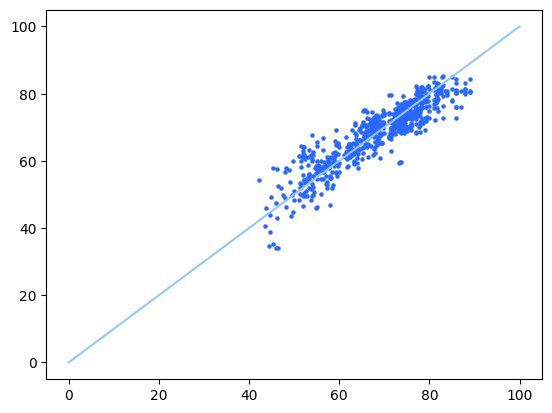

Intercept: 69.4735655737705
RMSE for val: 4.126519235588279
RMSE for test: 4.032187999542108
MAE for val: 3.090743345595684
MAE for test: 3.0404509842804535


In [18]:
scaler = StandardScaler().fit(Xtrain)

Xtrain_scaled = scaler.transform(Xtrain)
Xval_scaled = scaler.transform(Xval)
Xtest_scaled = scaler.transform(Xtest)

clf_scaled = LinearRegression()
clf_scaled.fit(Xtrain_scaled,ytrain)

plt.scatter(yval, clf_scaled.predict(Xval_scaled), color="#2968ff", s=5)
plt.plot([0,100], [0,100], '#94c6ff')
plt.show()

print('Intercept:', clf_scaled.intercept_)
print('RMSE for val:', np.sqrt(mean_squared_error(np.array(yval), clf_scaled.predict(Xval_scaled))))
print('RMSE for test:', np.sqrt(mean_squared_error(np.array(ytest), clf_scaled.predict(Xtest_scaled))))
print('MAE for val:', mean_absolute_error(clf_scaled.predict(Xval_scaled), yval))
print('MAE for test:', mean_absolute_error(clf_scaled.predict(Xtest_scaled), ytest))

In [21]:
print("The differences between scaled and non scaled data using linear regression:")
print("...when the number is negative, it means scaled data has better result...")
print('RMSE on val:', 
np.sqrt(mean_squared_error(np.array(yval), clf_scaled.predict(Xval_scaled), squared = False)) - 
np.sqrt(mean_squared_error(np.array(yval), clf_lr.predict(Xval), squared = False)))
print('RMSE on test:',
np.sqrt(mean_squared_error(np.array(ytest), clf_scaled.predict(Xtest_scaled), squared = False))-
np.sqrt(mean_squared_error(np.array(ytest), clf_lr.predict(Xtest), squared = False)))
print('MAE on val:',
mean_absolute_error(clf_scaled.predict(Xval_scaled), yval) -
mean_absolute_error(clf_lr.predict(Xval), yval))
print('MAE on test:',
mean_absolute_error(clf_scaled.predict(Xtest_scaled), ytest) -
mean_absolute_error(clf_lr.predict(Xtest), ytest))

The differences between scaled and non scaled data using linear regression:
...when the number is negative, it means scaled data has better result...
RMSE on val: 3.019806626980426e-14
RMSE on test: -9.769962616701378e-15
MAE on val: 9.370282327836321e-14
MAE on test: -4.75175454539567e-14


Je vidět, že standardizace výrazně nepomohla. Výsledeky jsou velmi podobné. Drobné zlepšení můžeme vidět na množině testovacích dat.

Nyní použiji hřebenovou regresi a chybu vyjádřím stejně jako u lineární regrese. Pro nalezení nejlepšího hyperparametru alfa použiji funkci optimize.minimize_scalar ve scklearn. Na základě nejlepší hodnoty alfa určím RMSE a MAE

In [22]:
def get_opt_ridge_model(Xtrain, Xval):
    def ridgemodel_eval(alpha):
        clf = Ridge(alpha=alpha)
        clf.fit(Xtrain, ytrain)
        return mean_squared_error(yval, clf.predict(Xval), squared = False)

    alphas = np.linspace(0,100,100)
    alphas_res = [ridgemodel_eval(alpha) for alpha in alphas]
    plt.plot(alphas, alphas_res, '.')
    plt.show()
    
    opt_alpha = optimize.minimize_scalar(ridgemodel_eval, options = {'maxiter': 100}, method = 'bounded', bounds=(0.1, 100))
    print(opt_alpha)

    clf_opt_ridge = Ridge(alpha = opt_alpha.x)
    clf_opt_ridge.fit(Xtrain, ytrain)
    return clf_opt_ridge

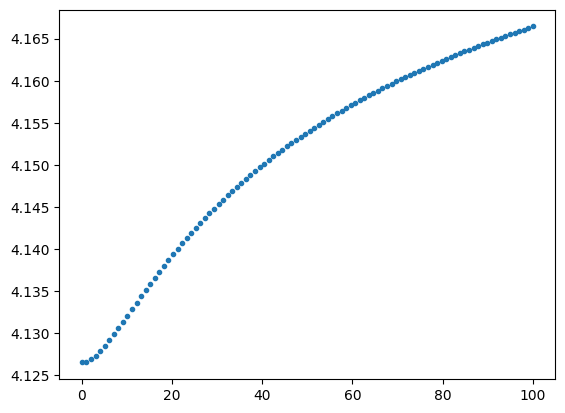

     fun: 4.126516961145465
 message: 'Solution found.'
    nfev: 20
     nit: 20
  status: 0
 success: True
       x: 0.13412853493482904


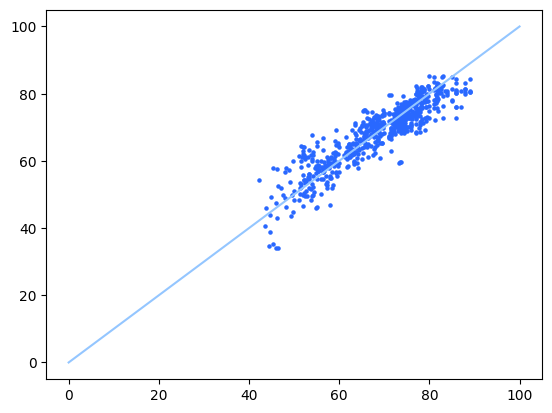

Intercept: 40.81181912220153
RMSE for val: 4.126516961145465
RMSE for test: 4.032283824522953
MAE for val: 3.090866370665915
MAE for test: 3.0406867200633005


In [23]:
clf_opt_ridge = get_opt_ridge_model(Xtrain, Xval)

plt.scatter(yval, clf_opt_ridge.predict(Xval), color="#2968ff", s=5)
plt.plot([0,100], [0,100], '#94c6ff')
plt.show()

print('Intercept:', clf_opt_ridge.intercept_)
print('RMSE for val:', np.sqrt(mean_squared_error(np.array(yval), clf_opt_ridge.predict(Xval))))
print('RMSE for test:', np.sqrt(mean_squared_error(np.array(ytest), clf_opt_ridge.predict(Xtest))))
print('MAE for val:', mean_absolute_error(clf_opt_ridge.predict(Xval), yval))
print('MAE for test:', mean_absolute_error(clf_opt_ridge.predict(Xtest), ytest))

Výsledky jsou velmi podobné jako u lineární regrese. Pro zlepšení zkusím použít normalizaci dat.

In [24]:
Xtrain_norm = preprocessing.normalize(Xtrain, norm='l2')
Xtest_norm = preprocessing.normalize(Xtest, norm='l2')
Xval_norm = preprocessing.normalize(Xval, norm='l2')

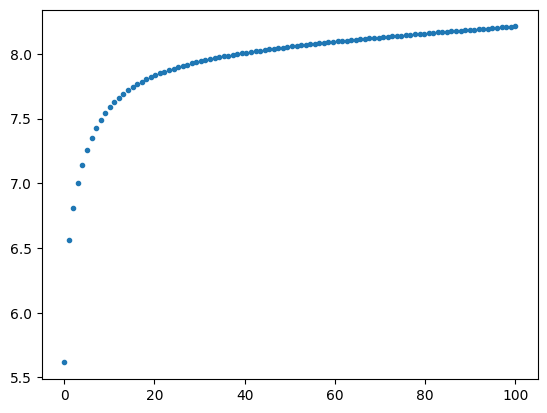

     fun: 6.186927132191765
 message: 'Solution found.'
    nfev: 35
     nit: 35
  status: 0
 success: True
       x: 0.1000044992221389


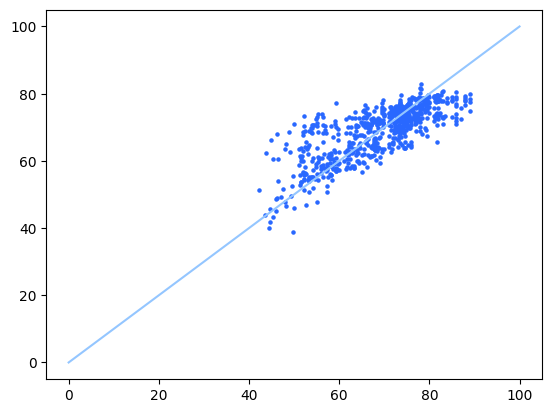

Intercept: 72.64514242385113
RMSE for val: 6.186927132191765
RMSE for test: 5.813117655597652
MAE for val: 4.5999251566332235
MAE for test: 4.278395465967954


In [26]:
clf_opt_ridge_norm = get_opt_ridge_model(Xtrain_norm, Xval_norm)

plt.scatter(yval, clf_opt_ridge_norm.predict(Xval_norm), color="#2968ff", s=5)
plt.plot([0,100], [0,100], '#94c6ff')
plt.show()

print('Intercept:', clf_opt_ridge_norm.intercept_)
print('RMSE for val:', np.sqrt(mean_squared_error(np.array(yval), clf_opt_ridge_norm.predict(Xval_norm))))
print('RMSE for test:', np.sqrt(mean_squared_error(np.array(ytest), clf_opt_ridge_norm.predict(Xtest_norm))))
print('MAE for val:', mean_absolute_error(clf_opt_ridge_norm.predict(Xval_norm), yval))
print('MAE for test:', mean_absolute_error(clf_opt_ridge_norm.predict(Xtest_norm), ytest))

Zde se výsledek výrazně zhoršil.

Zkusí ještě natrénoval hřebenovou regresi se standardizovanými daty. 

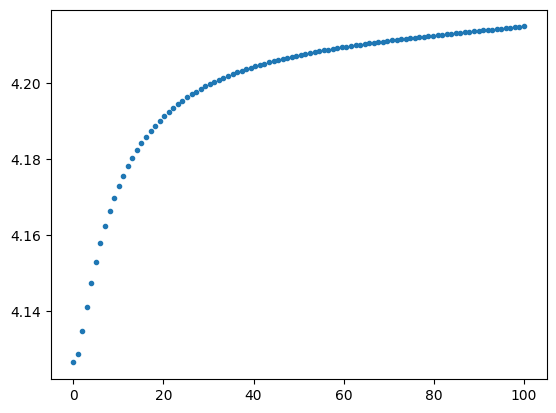

     fun: 4.126370219581135
 message: 'Solution found.'
    nfev: 20
     nit: 20
  status: 0
 success: True
       x: 0.16957489354442537


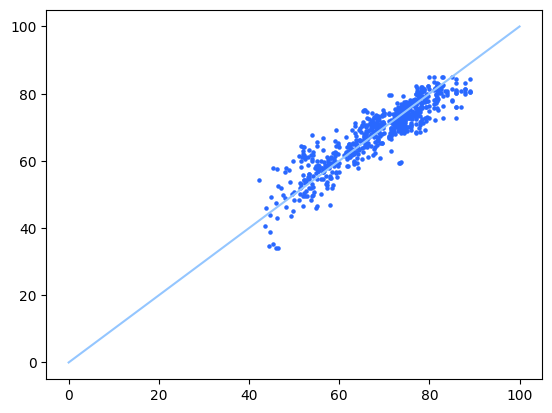

Intercept: 69.4735655737705
RMSE for val: 4.126370219581135
RMSE for test: 4.033622452575152
MAE for val: 3.089516299717394
MAE for test: 3.0401540700840326


In [27]:
clf_opt_ridge_scaled = get_opt_ridge_model(Xtrain_scaled, Xval_scaled)

plt.scatter(yval, clf_opt_ridge_scaled.predict(Xval_scaled), color="#2968ff", s=5)
plt.plot([0,100], [0,100], '#94c6ff')
plt.show()

print('Intercept:', clf_opt_ridge_scaled.intercept_)
print('RMSE for val:', np.sqrt(mean_squared_error(np.array(yval), clf_opt_ridge_scaled.predict(Xval_scaled))))
print('RMSE for test:', np.sqrt(mean_squared_error(np.array(ytest), clf_opt_ridge_scaled.predict(Xtest_scaled))))
print('MAE for val:', mean_absolute_error(clf_opt_ridge_scaled.predict(Xval_scaled), yval))
print('MAE for test:', mean_absolute_error(clf_opt_ridge_scaled.predict(Xtest_scaled), ytest))

Zde je narozdíl od modelu nad normalizovanými daty výsledek velmi podobný obyčejné lineární a hřebenové regresi.

Jako další model zvolím "KNeighbotsRegressor", tedy metodu nejbližších sousedů pro spojitou cílovou proměnnou.

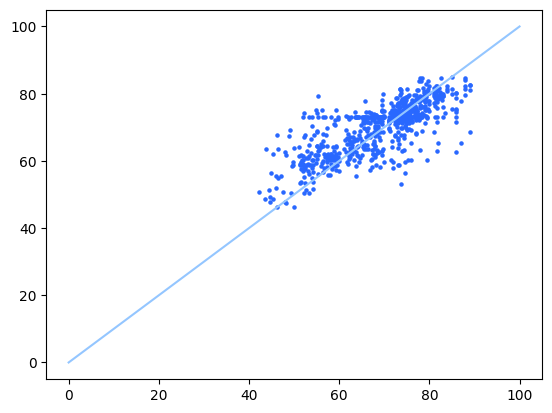

RMSE for val: 6.40414090764931
RMSE for test: 6.37023757609999
MAE for val: 4.6416939890710385
MAE for test: 4.444972677595628


In [28]:
neigh = KNeighborsRegressor(n_neighbors=5)
neigh.fit(Xtrain, ytrain)

plt.scatter(yval, neigh.predict(Xval), color="#2968ff", s=5)
plt.plot([0,100], [0,100], '#94c6ff')
plt.show()

print('RMSE for val:', np.sqrt(mean_squared_error(np.array(yval), neigh.predict(Xval))))
print('RMSE for test:', np.sqrt(mean_squared_error(np.array(ytest), neigh.predict(Xtest))))
print('MAE for val:', mean_absolute_error(neigh.predict(Xval), yval))
print('MAE for test:', mean_absolute_error(neigh.predict(Xtest), ytest))

Výsledek je jeden z nejhorších, který jsem v porovnání s ostatními modely dostala. Zkusím ještě natrénovat "KNeighbotsRegressor" se standardizovanými daty.

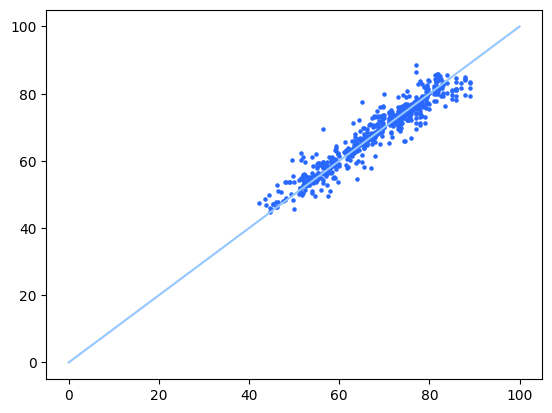

RMSE for val: 2.855837780097026
RMSE for test: 3.3048699370090873
MAE for val: 1.8694672131147538
MAE for test: 1.9739071038251368


In [30]:
neigh_scaled = KNeighborsRegressor(n_neighbors=2)
neigh_scaled.fit(Xtrain_scaled, ytrain)

plt.scatter(yval, neigh_scaled.predict(Xval_scaled), color="#2968ff", s=5)
plt.plot([0,100], [0,100], '#94c6ff')
plt.show()

print('RMSE for val:', np.sqrt(mean_squared_error(np.array(yval), neigh_scaled.predict(Xval_scaled))))
print('RMSE for test:', np.sqrt(mean_squared_error(np.array(ytest), neigh_scaled.predict(Xtest_scaled))))
print('MAE for val:', mean_absolute_error(neigh_scaled.predict(Xval_scaled), yval))
print('MAE for test:', mean_absolute_error(neigh_scaled.predict(Xtest_scaled), ytest))

Výsledek je velmi dobrý, nejlepší ze všech modelů. Zkusím si ještě najít hodnotu "n_neighbors" pro nejnižší RMSE pomocí grafu.

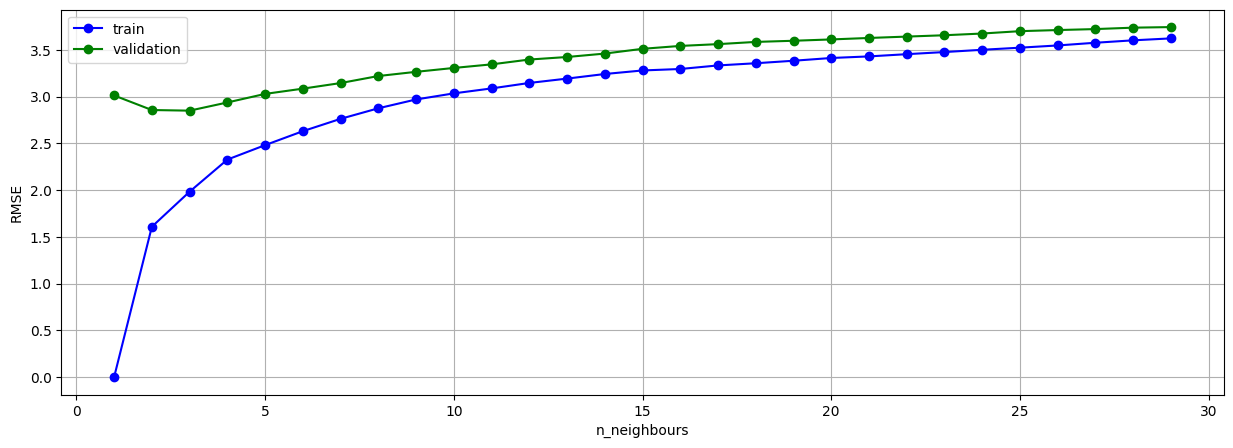

In [31]:
kNN_val_accuracy = []
kNN_train_accuracy = []

kneighbors = range(1,30)
for k in kneighbors:
    neigh_scaled = KNeighborsRegressor(n_neighbors = k)
    neigh_scaled.fit(Xtrain_scaled, ytrain)
    kNN_val_accuracy.append(np.sqrt(mean_squared_error(np.array(yval), neigh_scaled.predict(Xval_scaled))))
    kNN_train_accuracy.append(np.sqrt(mean_squared_error(np.array(ytrain), neigh_scaled.predict(Xtrain_scaled))))

plt.figure(figsize=(15,5))
plt.plot(kneighbors, kNN_train_accuracy,"ob-")
plt.plot(kneighbors, kNN_val_accuracy,"og-")
plt.grid(True)
plt.xlabel("n_neighbours")
plt.ylabel("RMSE")
plt.legend(["train", "validation"])

Je vidět, že graf ukazuje nejlepší RMSE na validační množně pro 2 nebo 3 sousedy. Dosadím tuto hodnotu tedy do modelu.

### Vyhodnocení a závěr

Vytvořila jsem 7 modelů. Vyzkoušela jsem natrénovat model se standardizovanými daty a normalizovanými daty, lineární a hřebenovou regresi a nakonec kNN regresi. Normalizace dat mi výsledek nezlepšila. Standardizace ano. Výrazně zlepšila výsledek kNN regrese, mírně u lineární a hřebenové, tam jej zlepšila až ve vyšších řádech desetinných míst. 

Nejlepší model na základě hodnoty RMSE mi vyšel kNN regrese se standardizovanými daty, takže ten bych použila pro predikci na úplně neznámých datech.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=37f480b5-d6f6-46f1-850c-49b89b6cdda3' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>